In this notebook you will find:
 - testing different imputing strategies and evaluating them using CV prediction recall and AUPRC
 Those tests conclueded by:
 - imputing fall_how_many_last12months with hot deck didnt lead to convincing resutls
 - imputing as categorical instead of imputing as dummies also lead to convincing results
 - all tests were done using a simple decisiontree, which probably isnt the best method to use since it can overfit very easily
 - also some conclusion were drawn on the feature importance the tree can return for every variable which decodes how often the variable was used in every split; however using feature importance isnt recommended
 - that is why in the CatBoostSHAP notebook I use SHAP values intead

In [1]:
import pandas as pd
# %pip install autoviz
#from autoviz.AutoViz_Class import AutoViz_Class
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    precision_recall_curve, roc_auc_score, confusion_matrix, classification_report, auc
)

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
pwd()

'c:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionPoetry\\repos\\Applied-Science-Portfoliolio'

In [4]:
path = "C:\\Users\\felix\\OneDrive\\Dokumente\\FU_Working\\ApplAna\\FallPredictionPoetry\\data\\kip_sdm_syn.csv"
df = pd.read_csv(path, sep=",")

In [5]:
# Split into train (80%) and test (20%)
df, test_df = train_test_split(df, test_size=0.1, stratify=df["fallen"], random_state=42)

## Dataset Creation One-Hot Encoding

In [70]:
df["transfer"].value_counts()

transfer
2     2016
3      436
4A     166
1       86
4B      10
Name: count, dtype: int64

In [6]:
df['transfer'] = df['transfer'].fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer'])


In [7]:
df["bed_mobility-jones"].value_counts()

bed_mobility-jones
2     1501
3      445
4A     129
1       79
4B       5
Name: count, dtype: int64

In [8]:
df['bed_mobility-jones'] = df['bed_mobility-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-jones'])

In [9]:
df['walk-jones'] = df['walk-jones'].fillna('Unknown')
df = pd.get_dummies(df, columns=['walk-jones'])

In [10]:
df['decubitus-risk'] = df['decubitus-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['decubitus-risk'])

In [11]:
df['fall-risk'] = df['fall-risk'].fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-risk'])

### Always Execute

In [12]:
df['procedure'] = df['procedure'].fillna('Unknown')
df = pd.get_dummies(df, columns=['procedure'])

In [13]:
df['diagnosis'] = df['diagnosis'].fillna('Unknown')
df = pd.get_dummies(df, columns=['diagnosis'])

In [14]:
df['sex'] = df['sex'].fillna('Unknown')
df = pd.get_dummies(df, columns=['sex'])

In [15]:
df["decubitus-admission"] = df["decubitus-admission"].astype("boolean")
df["decubitus-at_the_moment"] = df["decubitus-at_the_moment"].astype("boolean")
df["bed_mobility-impairment"] = df["bed_mobility-impairment"].astype("boolean")
df["bed_mobility-skin_condition"] = df["bed_mobility-skin_condition"].astype("boolean")
df["transfer-impairment"] = df["transfer-impairment"].astype("boolean")
df["medical_items"] = df["medical_items"].astype("boolean")
df["medical_items-skin_condition_at_item_application"] = df["medical_items-skin_condition_at_item_application"].astype("boolean")
df["fall-last_12_month"] = df["fall-last_12_month"].astype("boolean")
df["fall-while_stay"] = df["fall-while_stay"].astype("boolean")
df["fall-while_transfer"] = df["fall-while_transfer"].astype("boolean")
df["walk-impairment"] = df["walk-impairment"].astype("boolean")
df["excretions-impairment"] = df["excretions-impairment"].astype("boolean")
df["cognition-impairment"] = df["cognition-impairment"].astype("boolean")
df["psychotropic_or_sedatives_drugs"] = df["psychotropic_or_sedatives_drugs"].astype("boolean")
df["diseases"] = df["diseases"].astype("boolean")

### Additional encodings to fix NaNs

In [16]:
df["fall-how_many_last_12_month_missing"] = df["fall-how_many_last_12_month"].isna().astype(int)

In [17]:
df['fall-while_stay'] = df['fall-while_stay'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['fall-while_stay'])

In [18]:
df['transfer-impairment'] = df['transfer-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['transfer-impairment'])

In [19]:
df['bed_mobility-impairment'] = df['bed_mobility-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['bed_mobility-impairment'])

### Experiment What Happens if fall-howmany-12_moth is not hot-deck encoded?

In [57]:
na_count_per_column = df.isna().sum().to_string()
print(na_count_per_column)

fallen                                                  0
id                                                      0
age                                                     0
c_zriserh1                                              0
decubitus-admission                                 27539
decubitus-at_the_moment                             27306
bed_mobility-skin_condition                         34601
medical_items                                       26263
medical_items-arm_or_leg_splint                         0
medical_items-A_V_system                                0
medical_items-plaster_or_neck_brace                     0
medical_items-compression_stocking                      0
medical_items-ventilation_mask                          0
medical_items-O2_glasses                                0
medical_items-orthesis                                  0
medical_items-prosthesis                                0
medical_items-skin_condition_at_item_application    34758
fall-last_12_m

We compared models for imputed values with highest correlation

In [58]:
train_columns = ["id", "age","walk-balance_and_gait_impaired", "fall-how_many_last_12_month", "excretions-incontinence", "fall-risk_Unknown", "fall-risk_0", "fall-risk_+", "fall-risk_++", "fall-while_stay_False","fall-while_stay_True", "fall-while_stay_Unknown", "transfer-impairment_False", "transfer-impairment_Unknown", "transfer-impairment_True","bed_mobility-impairment_False", "bed_mobility-impairment_True", "bed_mobility-impairment_Unknown", "fall-how_many_last_12_month_missing", "fallen"] 
df1 = df[train_columns]

In [94]:

def decision_tree_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen", "id"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    dt = DecisionTreeClassifier(random_state=42)
    param_grid = {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 3, 5]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(dt, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_tree = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_tree.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = best_tree.predict(X_test)
    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_tree, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_probs)

    print(f"AUC-PR Score: {auc_pr:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_tree.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

            


Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation recall: 0.1319

Test set performance with optimized hyperparameters:
Recall: 0.1176
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.33      0.12      0.17        17

    accuracy                           1.00      7200
   macro avg       0.67      0.56      0.59      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.1987
ROC-AUC Score: 0.8717


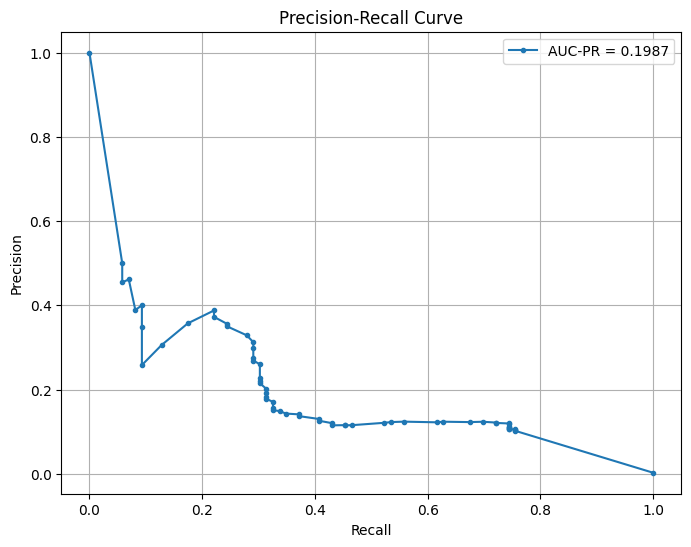

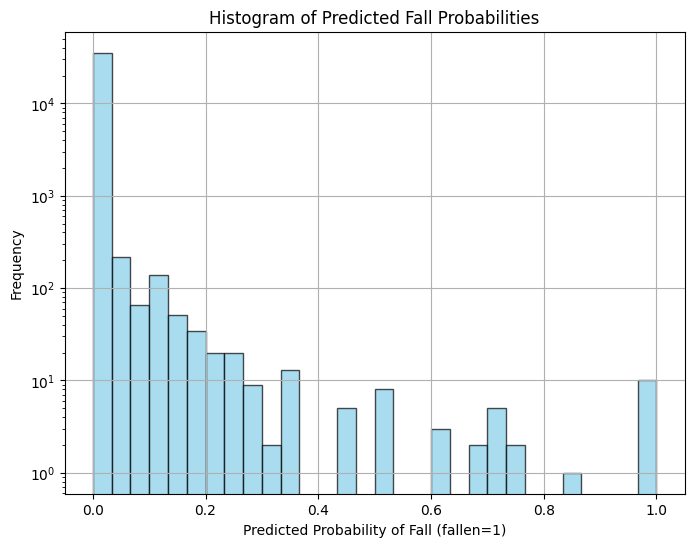

Best Threshold for Precision-Recall Balance: 0.2500


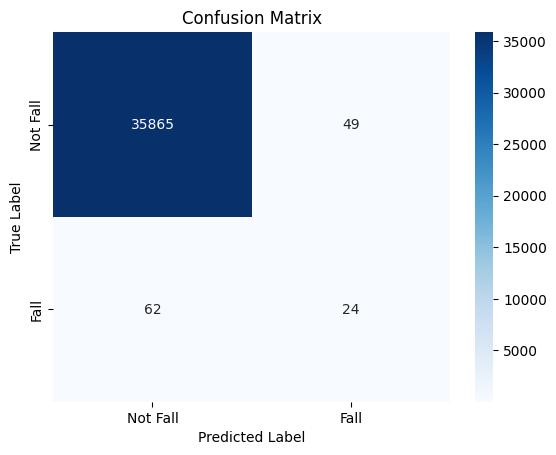

Top 10 Important Features:
                                Feature  Importance
0                                   age    0.256007
1        walk-balance_and_gait_impaired    0.253699
9                  fall-while_stay_True    0.226026
13             transfer-impairment_True    0.070554
12          transfer-impairment_Unknown    0.046656
2           fall-how_many_last_12_month    0.030570
15         bed_mobility-impairment_True    0.026094
17  fall-how_many_last_12_month_missing    0.020764
10              fall-while_stay_Unknown    0.020246
14        bed_mobility-impairment_False    0.019514


In [60]:
decision_tree_pipeline(df1)

In [61]:
df['fall-how_many_last_12_month'].corr(df['fallen'], method='pearson')

np.float64(0.21530210766180022)

### Hot Deck Encoding

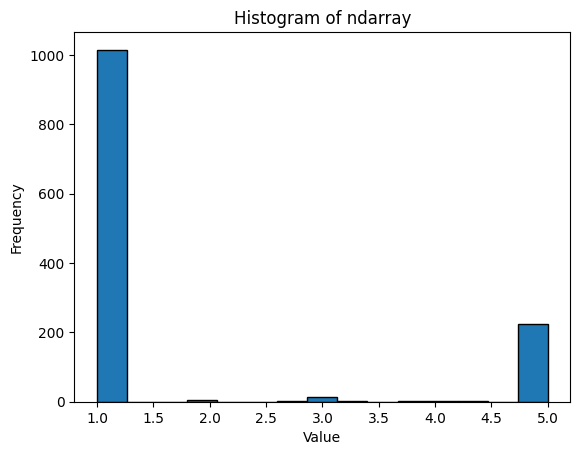

In [62]:
plt.hist(df["fall-how_many_last_12_month"], bins=15, edgecolor='black')  # Increase bins for finer granularity
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of ndarray")
plt.show()

In [64]:
# Step 1: Copy the column to a new column
df['fall_scrambled'] = df['fall-how_many_last_12_month'].copy()

# Step 2: Remove missing values and randomly shuffle the column
non_missing_values = df['fall_scrambled'].dropna().sample(frac=1, random_state=42).values  # Shuffle

# Step 3: Replicate values so that there are as many as needed
num_missing = df['fall-how_many_last_12_month'].isna().sum()
replicated_values = np.tile(non_missing_values, (num_missing // len(non_missing_values) + 1))[:num_missing]

# Step 4: Join the scrambled column with the original DataFrame
df.loc[df['fall-how_many_last_12_month'].isna(), 'fall-how_many_last_12_month'] = replicated_values

# Step 5: Drop the scrambled column (optional)
df.drop(columns=['fall_scrambled'], inplace=True)

# Check if missing values are imputed
print(df['fall-how_many_last_12_month'].isna().sum())  # Should be 0 if all NaNs were filled

0


In [65]:
df['fall-how_many_last_12_month'].corr(df['fallen'], method='pearson')

np.float64(0.01311584989954838)

In [66]:
train_columns = ["id", "age","walk-balance_and_gait_impaired", "fall-how_many_last_12_month", "excretions-incontinence", "fall-risk_Unknown", "fall-risk_0", "fall-risk_+", "fall-risk_++", "fall-while_stay_False","fall-while_stay_True", "fall-while_stay_Unknown", "transfer-impairment_False", "transfer-impairment_Unknown", "transfer-impairment_True","bed_mobility-impairment_False", "bed_mobility-impairment_True", "bed_mobility-impairment_Unknown", "fall-how_many_last_12_month_missing", "fallen"] 
df1 = df[train_columns]


Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation recall: 0.1319

Test set performance with optimized hyperparameters:
Recall: 0.1176
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.33      0.12      0.17        17

    accuracy                           1.00      7200
   macro avg       0.67      0.56      0.59      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.1753
ROC-AUC Score: 0.8200


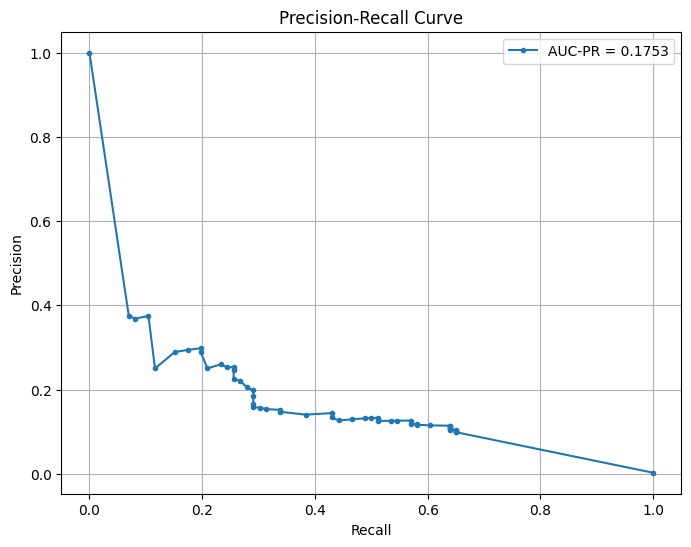

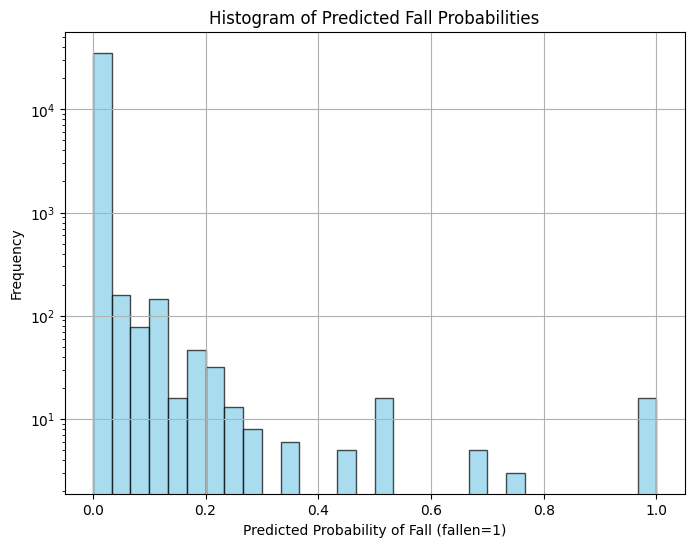

Best Threshold for Precision-Recall Balance: 0.0561


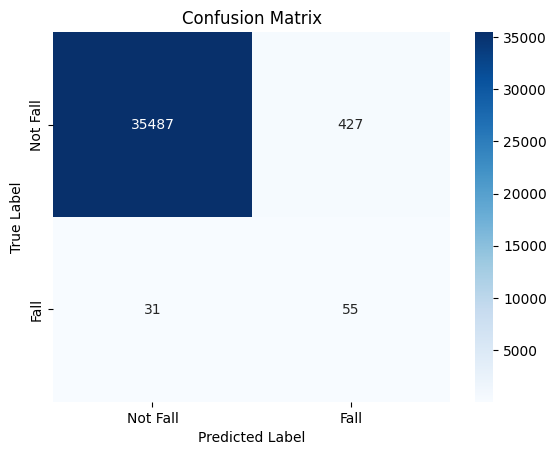

Top 10 Important Features:
                                Feature  Importance
0                                   age    0.270570
1        walk-balance_and_gait_impaired    0.203267
9                  fall-while_stay_True    0.181095
2           fall-how_many_last_12_month    0.121197
12          transfer-impairment_Unknown    0.061668
13             transfer-impairment_True    0.054268
17  fall-how_many_last_12_month_missing    0.037442
10              fall-while_stay_Unknown    0.019631
15         bed_mobility-impairment_True    0.018333
3               excretions-incontinence    0.015048


In [67]:
decision_tree_pipeline(df1)

### Conclusion of Experiment

We keep the variable as unimputed since neither imputing with with hot deck encoding does not yield convincing results.

At least not in a simple decision tree.

## Use other variables in the model that are highly correlated.

Variables not used so far:

walk abalnce and gait impaired

excretions incontinence

walking aid

cognittion agitated

excretions impairment

cognition impairment

fall while transfer

In [85]:
na_count_per_column = df.isna().sum().to_string()
print(na_count_per_column)

fallen                                                  0
id                                                      0
age                                                     0
c_zriserh1                                              0
decubitus-admission                                 27539
decubitus-at_the_moment                             27306
bed_mobility-skin_condition                         34601
medical_items                                       26263
medical_items-arm_or_leg_splint                         0
medical_items-A_V_system                                0
medical_items-plaster_or_neck_brace                     0
medical_items-compression_stocking                      0
medical_items-ventilation_mask                          0
medical_items-O2_glasses                                0
medical_items-orthesis                                  0
medical_items-prosthesis                                0
medical_items-skin_condition_at_item_application    34758
fall-last_12_m

cognition-impairment

excretions-impairment

In [86]:
df["cognition-impairment"].value_counts()

cognition-impairment
False    8548
True      485
Name: count, dtype: Int64

In [87]:
df["excretions-impairment"].value_counts()

excretions-impairment
False    8380
True      684
Name: count, dtype: Int64

In [20]:
df['excretions-impairment'] = df['excretions-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['excretions-impairment'])

In [21]:
df['cognition-impairment'] = df['cognition-impairment'].astype('object').fillna('Unknown')
df = pd.get_dummies(df, columns=['cognition-impairment'])

In [33]:
df.head()

,fallen,id,age,c_zriserh1,decubitus-admission,decubitus-at_the_moment,bed_mobility-skin_condition,medical_items,medical_items-arm_or_leg_splint,medical_items-A_V_system,...,transfer-impairment_Unknown,bed_mobility-impairment_False,bed_mobility-impairment_True,bed_mobility-impairment_Unknown,excretions-impairment_False,excretions-impairment_True,excretions-impairment_Unknown,cognition-impairment_False,cognition-impairment_True,cognition-impairment_Unknown
6690,False,77363,49,False,<NA>,False,<NA>,<NA>,False,False,...,True,True,False,False,False,False,True,False,False,True
35722,False,80749,34,True,<NA>,<NA>,<NA>,<NA>,False,False,...,False,False,False,True,False,False,True,False,False,True
32809,False,23355,39,False,<NA>,False,<NA>,<NA>,False,False,...,False,True,False,False,False,False,True,False,False,True
10660,False,36660,29,False,<NA>,<NA>,<NA>,False,False,False,...,True,False,False,True,True,False,False,False,False,True
33450,False,15012,54,False,<NA>,False,<NA>,False,False,False,...,True,False,False,True,True,False,False,False,False,True


In [ ]:
train_columns = ["id", "age", "fall-risk_0", "fall-risk_+", "fall-risk_++", "walk-balance_and_gait_impaired", "fall-how_many_last_12_month", "excretions-incontinence", "fall-while_stay_True", "fall-while_stay_Unknown", "transfer-impairment_Unknown", "transfer-impairment_True", "bed_mobility-impairment_False", "bed_mobility-impairment_True", "fall-how_many_last_12_month_missing", "fallen"] 
df1 = df[train_columns]

In [38]:

def decision_tree_pipeline(df):
    """
    Trains and evaluates a Decision Tree model with hyperparameter tuning, 
    finds the best threshold for recall/precision, and visualizes performance.

    Args:
        df (pd.DataFrame): The cleaned dataset.
        target_col (str): Target variable name.
        test_size (float): Train-test split ratio.
        random_state (int): Random seed for reproducibility.

    Returns:
        dict: Model performance metrics.
    """

    
    # === Load Data ===
    X = df.drop(columns=["fallen", "id"])  # Features
    y = df["fallen"]  # Target  

    # Split train/test sets
    # Use stratified sampling to ensure balanced class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


    # === Step 1: Define Model & Parameter Grid ===
    dt = DecisionTreeClassifier(random_state=42)
    param_grid = {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 3, 5]
    }

    # === Step 2: Hyperparameter Tuning using GridSearchCV ===
    grid_search = GridSearchCV(dt, param_grid, scoring="recall", cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model after tuning
    best_tree = grid_search.best_estimator_

    # Print the best parameters and best score
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"Best cross-validation recall: {grid_search.best_score_:.4f}")



    # Train a model with the best parameters
    best_tree.fit(X_train, y_train)

    # Evaluate on test set
    y_pred_best_tree = best_tree.predict(X_test)
    print(np.unique(y_pred_best_tree, return_counts=True))

    print("\nTest set performance with optimized hyperparameters:")
    print(f"Recall: {recall_score(y_test, y_pred_best_tree):.4f}")
    print(classification_report(y_test, y_pred_best_tree))


    # === Step 3: Cross-Validation Prediction for Evaluation ===
    cv = StratifiedKFold(n_splits=5)
    y_probs = cross_val_predict(best_tree, X, y, cv=cv, method="predict_proba")[:, 1]

    

    # === Step 4: Compute AUC-PR ===
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    auc_pr = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_probs)

    print(f"AUC-PR Score: {auc_pr:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")

    # === Step 5: Plot Precision-Recall Curve ===
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker=".", label=f"AUC-PR = {auc_pr:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # === Step 6: Histogram of Prediction Probabilities ===
    plt.figure(figsize=(8, 6))
    plt.hist(y_probs, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Histogram of Predicted Fall Probabilities")
    plt.xlabel("Predicted Probability of Fall (fallen=1)")
    plt.ylabel("Frequency")

    # Apply logarithmic scale to y-axis
    plt.yscale('log')
    plt.grid(True)
    plt.show()

    # === Step 7: Find Best Threshold for Recall-Precision Tradeoff ===
    best_threshold = thresholds[np.argmax(precision * recall)]
    print(f"Best Threshold for Precision-Recall Balance: {best_threshold:.4f}")

    # Apply the best threshold
    y_pred = (y_probs >= best_threshold).astype(int)

    # === Step 8: Confusion Matrix ===
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fall", "Fall"], yticklabels=["Not Fall", "Fall"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # === Step 9: Feature Importance ===
    feature_importances = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_tree.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    print("Top 10 Important Features:")
    print(feature_importances.head(30))

            


Best parameters found:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation recall: 0.1165
(array([False,  True]), array([7196,    4]))

Test set performance with optimized hyperparameters:
Recall: 0.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7183
        True       0.00      0.00      0.00        17

    accuracy                           1.00      7200
   macro avg       0.50      0.50      0.50      7200
weighted avg       1.00      1.00      1.00      7200

AUC-PR Score: 0.1991
ROC-AUC Score: 0.8604


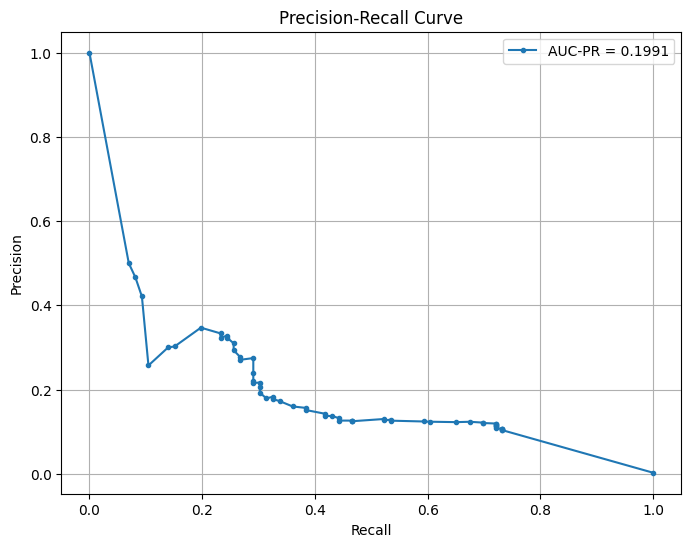

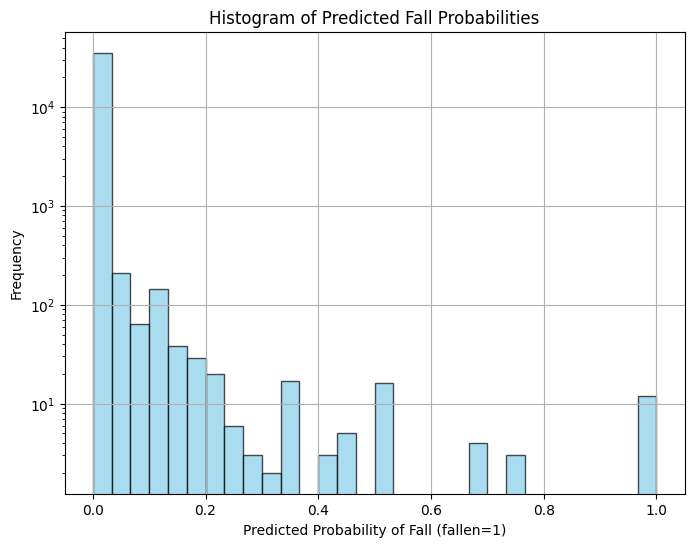

Best Threshold for Precision-Recall Balance: 0.0526


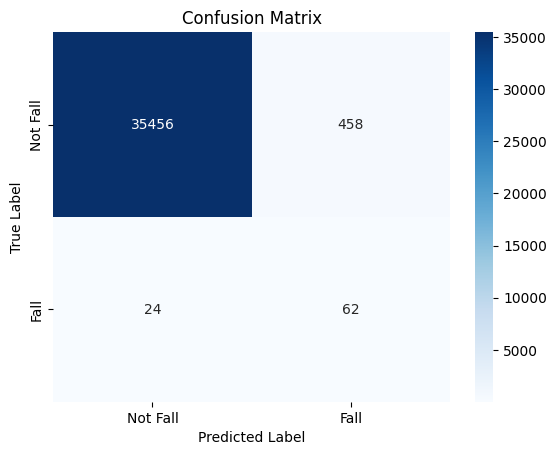

Top 10 Important Features:
                                Feature  Importance
0                                   age    0.313227
4        walk-balance_and_gait_impaired    0.224307
7                  fall-while_stay_True    0.199840
10             transfer-impairment_True    0.067614
9           transfer-impairment_Unknown    0.042580
6               excretions-incontinence    0.036466
5           fall-how_many_last_12_month    0.030710
12         bed_mobility-impairment_True    0.022861
13  fall-how_many_last_12_month_missing    0.020518
8               fall-while_stay_Unknown    0.020074
11        bed_mobility-impairment_False    0.018192
2                           fall-risk_+    0.003611
3                          fall-risk_++    0.000000
1                           fall-risk_0    0.000000


In [49]:
decision_tree_pipeline(df1)

To me it looks like always keeping the Unknown/True/False encodes redudant information. Therefore one of them was dropped. AUCPR improved.

Weird things happen: the rest of the fall-risk dummies all have zero feature importance. However dropping them reduces the AUCRC. Also the test recall drops to zero?!

Adding all excretion-impairment and cognition-impairment dummys reduces AUCRC